# Titanic - XGBoost - TJS

## Packages

In [1]:
import numpy as np
import pandas as pd

pd.set_option("display.max_rows", 50)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## Data

In [2]:
df_train = pd.read_csv('/kaggle/input/titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')

## Helper Functions

In [3]:
def custom_hist(df):
    num_features = df.select_dtypes(include='number').shape[1]
    rows = -(-num_features // 2)

    return df.hist(figsize=(12, 4 * rows), layout=(rows, 2))

## EDA (Exploratory Data Analysis)

In [4]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
df_train.describe(include='O')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Fare'}>, <Axes: >, <Axes: >]],
      dtype=object)

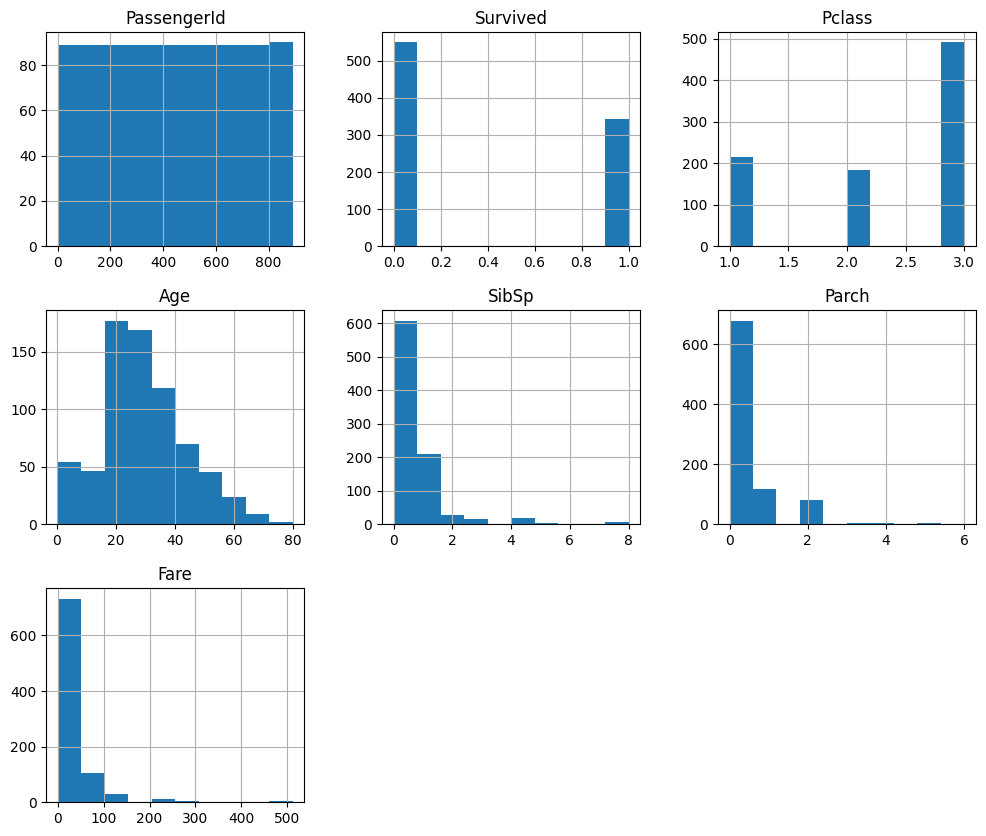

In [8]:
df_train.hist(figsize=(12,10))

### Null Exploration

#### Age

In [9]:
df_train[(df_train['Age'].isnull())].head(10)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
29,30,0,3,"Todoroff, Mr. Lalio",male,NaN,0,0,349216,7.8958,NaN,S
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C
32,33,1,3,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q
36,37,1,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,NaN,C
42,43,0,3,"Kraeff, Mr. Theodor",male,NaN,0,0,349253,7.8958,NaN,C


array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Fare'}>, <Axes: >, <Axes: >]],
      dtype=object)

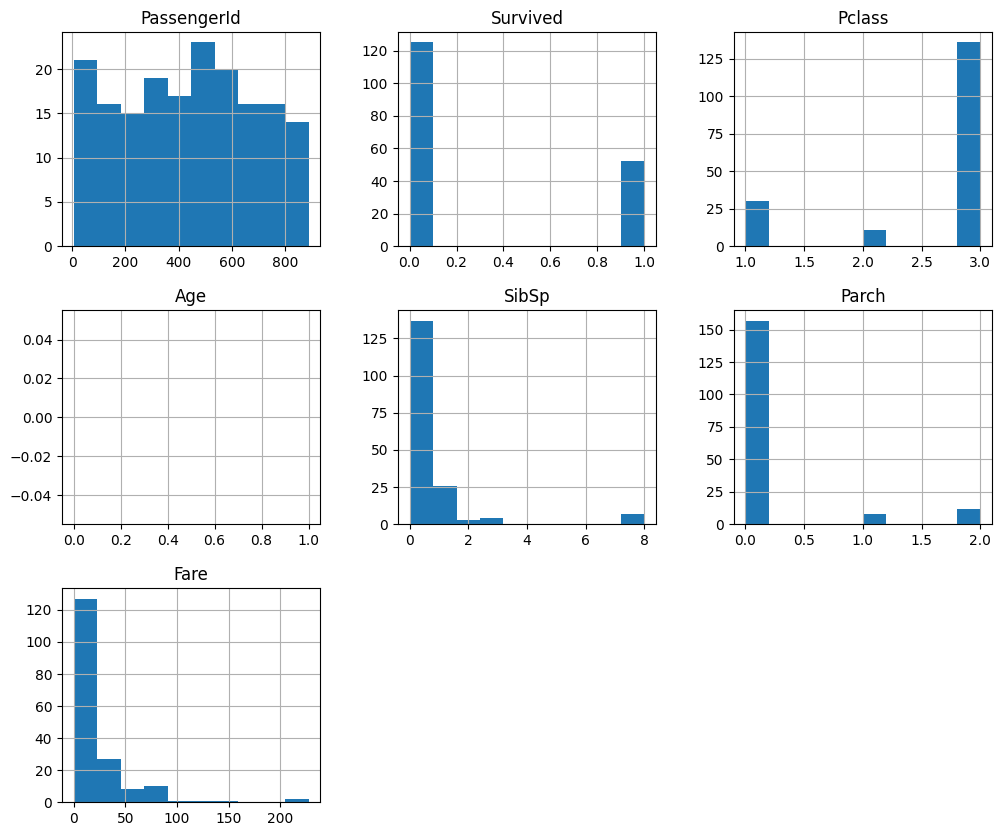

In [10]:
df_train[(df_train['Age'].isnull())].hist(figsize=(12,10))

In [11]:
mean_age = df_train['Age'].mean()
median_age = df_train['Age'].median()

print(f"Mean Age: {mean_age}\nMedian Age: {median_age}")

Mean Age: 29.69911764705882
Median Age: 28.0


In [12]:
#df_train['Age'] = df_train['Age'].fillna(median_age)
#df_train[(df_train['Age'].isnull())].head(10)

#### Cabin

In [13]:
df_train[df_train['Cabin'].isnull()].head(10)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C
12,13,0,3,"Saundercock, Mr. William Henry",male,20.0,0,0,A/5. 2151,8.0500,NaN,S
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S
14,15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.0,0,0,350406,7.8542,NaN,S


array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Fare'}>, <Axes: >, <Axes: >]],
      dtype=object)

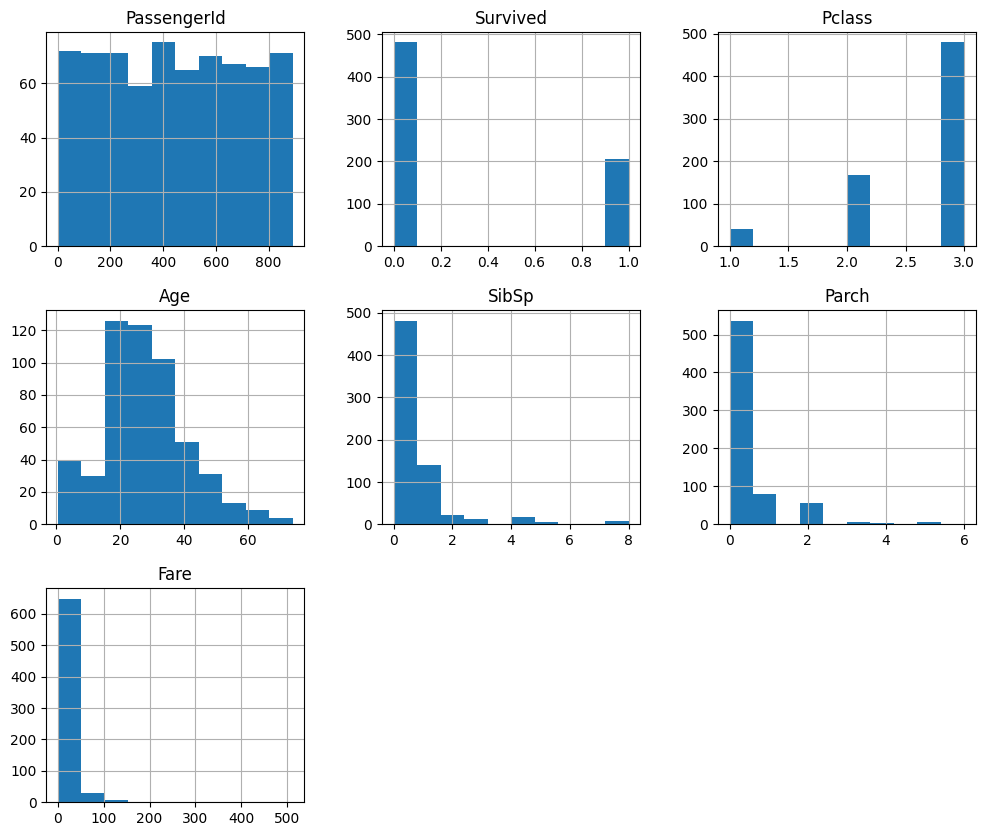

In [14]:
df_train[df_train['Cabin'].isnull()].hist(figsize=(12,10))

#### Embarked

In [15]:
df_train[df_train['Embarked'].isnull()].head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


#### Function

In [16]:
def null_cleaning(df):
    # We are leaving NULLs because XGBoost can handle them so this function serves only as a placeholder
    
    return clean_df

## Feature Engineering

In [17]:
# Sex -> IsMale
df_train['IsMale'] = df_train['Sex'].apply(lambda x: 1 if x == 'male' else 0)
df_train.drop(columns=['Sex'], inplace=True)

In [18]:
# Cabin -> CabinType, CabinNumber
df_train['CabinType'] = df_train['Cabin'].str[:1]
df_train['CabinNumber'] = pd.to_numeric(df_train['Cabin'].str[1:], errors='coerce')
df_train = df_train.drop(columns=['Cabin'])

# CabinType -> IsCabinType, IsCabinTypeA, IsCabinTypeB, IsCabinTypeC, IsCabinTypeD, IsCabinTypeE, IsCabinTypeF, IsCabinTypeG, IsCabinTypeT
df_train['isCabinType'] = df_train['CabinType'].notna().astype('Int64')
df_train['IsCabinTypeA'] = df_train['CabinType'].apply(lambda x: 1 if x == 'A' else 0)
df_train['IsCabinTypeB'] = df_train['CabinType'].apply(lambda x: 1 if x == 'B' else 0)
df_train['IsCabinTypeC'] = df_train['CabinType'].apply(lambda x: 1 if x == 'C' else 0)
df_train['IsCabinTypeD'] = df_train['CabinType'].apply(lambda x: 1 if x == 'D' else 0)
df_train['IsCabinTypeE'] = df_train['CabinType'].apply(lambda x: 1 if x == 'E' else 0)
df_train['IsCabinTypeF'] = df_train['CabinType'].apply(lambda x: 1 if x == 'F' else 0)
df_train['IsCabinTypeG'] = df_train['CabinType'].apply(lambda x: 1 if x == 'G' else 0)
df_train['IsCabinTypeT'] = df_train['CabinType'].apply(lambda x: 1 if x == 'T' else 0)
df_train = df_train.drop(columns=['CabinType'])

In [19]:
# Embarked -> IsEmbarkedCherbourg, IsEmbarkedQueenstown, IsEmbarkedSouthampton
# No need to avoid multicollinearity issue since using XGBoost
df_train['IsEmbarkedCherbourg'] = df_train['Embarked'].apply(lambda x: 1 if x == 'C' else 0)
df_train['IsEmbarkedQueenstown'] = df_train['Embarked'].apply(lambda x: 1 if x == 'Q' else 0)
df_train['IsEmbarkedSouthampton'] = df_train['Embarked'].apply(lambda x: 1 if x == 'S' else 0)
df_train = df_train.drop(columns=['Embarked'])

In [20]:
# Pclass -> IsFirstClass, IsSecondClass, IsThirdClass
# No need to avoid multicollinearity issue since using XGBoost
df_train['IsFirstClass'] = df_train['Pclass'].apply(lambda x: 1 if x == 1 else 0)
df_train['IsSecondClass'] = df_train['Pclass'].apply(lambda x: 1 if x == 2 else 0)
df_train['IsThirdClass'] = df_train['Pclass'].apply(lambda x: 1 if x == 3 else 0)
df_train = df_train.drop(columns=['Pclass'])

In [21]:
# Name -> Title -> IsWomanMarried, IsUniqueTitle
df_train['Title'] = df_train['Name'].str.extract(r',\s*(\w+)\.', expand=False)
df_train['IsWomanMarried'] = (df_train['Title'] == 'Mrs').astype('Int64')

standard_titles = ['Mrs', 'Mr', 'Ms', 'Miss']
df_train['IsUniqueTitle'] = (~df_train['Title'].isin(standard_titles)).astype('Int64')
df_train = df_train.drop(columns=['Title','Name'])

In [22]:
# Fare -> IsFare, LogFare
df_train['FarePerPerson'] = (df_train['Fare'] / (1 + df_train['SibSp'] + df_train['Parch']))
#df_train['IsFare'] = (df_train['Fare'] > 0).astype('Int64') # Too few trues
#df_train['LogFare'] = df_train['Fare'].apply(lambda x: np.log(x) if x > 0 else np.nan)
df_train['LogFarePerPerson'] = df_train['FarePerPerson'].apply(lambda x: np.log(x) if x > 0 else np.nan)
df_train = df_train.drop(columns=['Fare','FarePerPerson'])

In [23]:
df_train.head(10)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,PassengerId,Survived,Age,SibSp,Parch,Ticket,IsMale,CabinNumber,isCabinType,IsCabinTypeA,...,IsCabinTypeT,IsEmbarkedCherbourg,IsEmbarkedQueenstown,IsEmbarkedSouthampton,IsFirstClass,IsSecondClass,IsThirdClass,IsWomanMarried,IsUniqueTitle,LogFarePerPerson
0,1,0,22.0,1,0,A/5 21171,1,NaN,0,0,...,0,0,0,1,0,0,1,0,0,1.287854
1,2,1,38.0,1,0,PC 17599,0,85.0,1,0,...,0,1,0,0,1,0,0,1,0,3.573515
2,3,1,26.0,0,0,STON/O2. 3101282,0,NaN,0,0,...,0,0,0,1,0,0,1,0,0,2.070022
3,4,1,35.0,1,0,113803,0,123.0,1,0,...,0,0,0,1,1,0,0,1,0,3.279030
4,5,0,35.0,0,0,373450,1,NaN,0,0,...,0,0,0,1,0,0,1,0,0,2.085672
5,6,0,NaN,0,0,330877,1,NaN,0,0,...,0,0,1,0,0,0,1,0,0,2.135148
6,7,0,54.0,0,0,17463,1,46.0,1,0,...,0,0,0,1,1,0,0,0,0,3.948596
7,8,0,2.0,3,1,349909,1,NaN,0,0,...,0,0,0,1,0,0,1,0,1,1.438650
8,9,1,27.0,0,2,347742,0,NaN,0,0,...,0,0,0,1,0,0,1,1,0,1.311328
9,10,1,14.0,1,0,237736,0,NaN,0,0,...,0,1,0,0,0,1,0,1,0,2.710407


In [24]:
df_train.dtypes

PassengerId                int64
Survived                   int64
Age                      float64
SibSp                      int64
Parch                      int64
Ticket                    object
IsMale                     int64
CabinNumber              float64
isCabinType                Int64
IsCabinTypeA               int64
IsCabinTypeB               int64
IsCabinTypeC               int64
IsCabinTypeD               int64
IsCabinTypeE               int64
IsCabinTypeF               int64
IsCabinTypeG               int64
IsCabinTypeT               int64
IsEmbarkedCherbourg        int64
IsEmbarkedQueenstown       int64
IsEmbarkedSouthampton      int64
IsFirstClass               int64
IsSecondClass              int64
IsThirdClass               int64
IsWomanMarried             Int64
IsUniqueTitle              Int64
LogFarePerPerson         float64
dtype: object

array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Survived'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>],
       [<Axes: title={'center': 'Parch'}>,
        <Axes: title={'center': 'IsMale'}>],
       [<Axes: title={'center': 'CabinNumber'}>,
        <Axes: title={'center': 'isCabinType'}>],
       [<Axes: title={'center': 'IsCabinTypeA'}>,
        <Axes: title={'center': 'IsCabinTypeB'}>],
       [<Axes: title={'center': 'IsCabinTypeC'}>,
        <Axes: title={'center': 'IsCabinTypeD'}>],
       [<Axes: title={'center': 'IsCabinTypeE'}>,
        <Axes: title={'center': 'IsCabinTypeF'}>],
       [<Axes: title={'center': 'IsCabinTypeG'}>,
        <Axes: title={'center': 'IsCabinTypeT'}>],
       [<Axes: title={'center': 'IsEmbarkedCherbourg'}>,
        <Axes: title={'center': 'IsEmbarkedQueenstown'}>],
       [<Axes: title={'center': 'IsEmbarkedSouthampton'}>,
        <Axes: title={'center': 'IsFirstClass'}>],
  

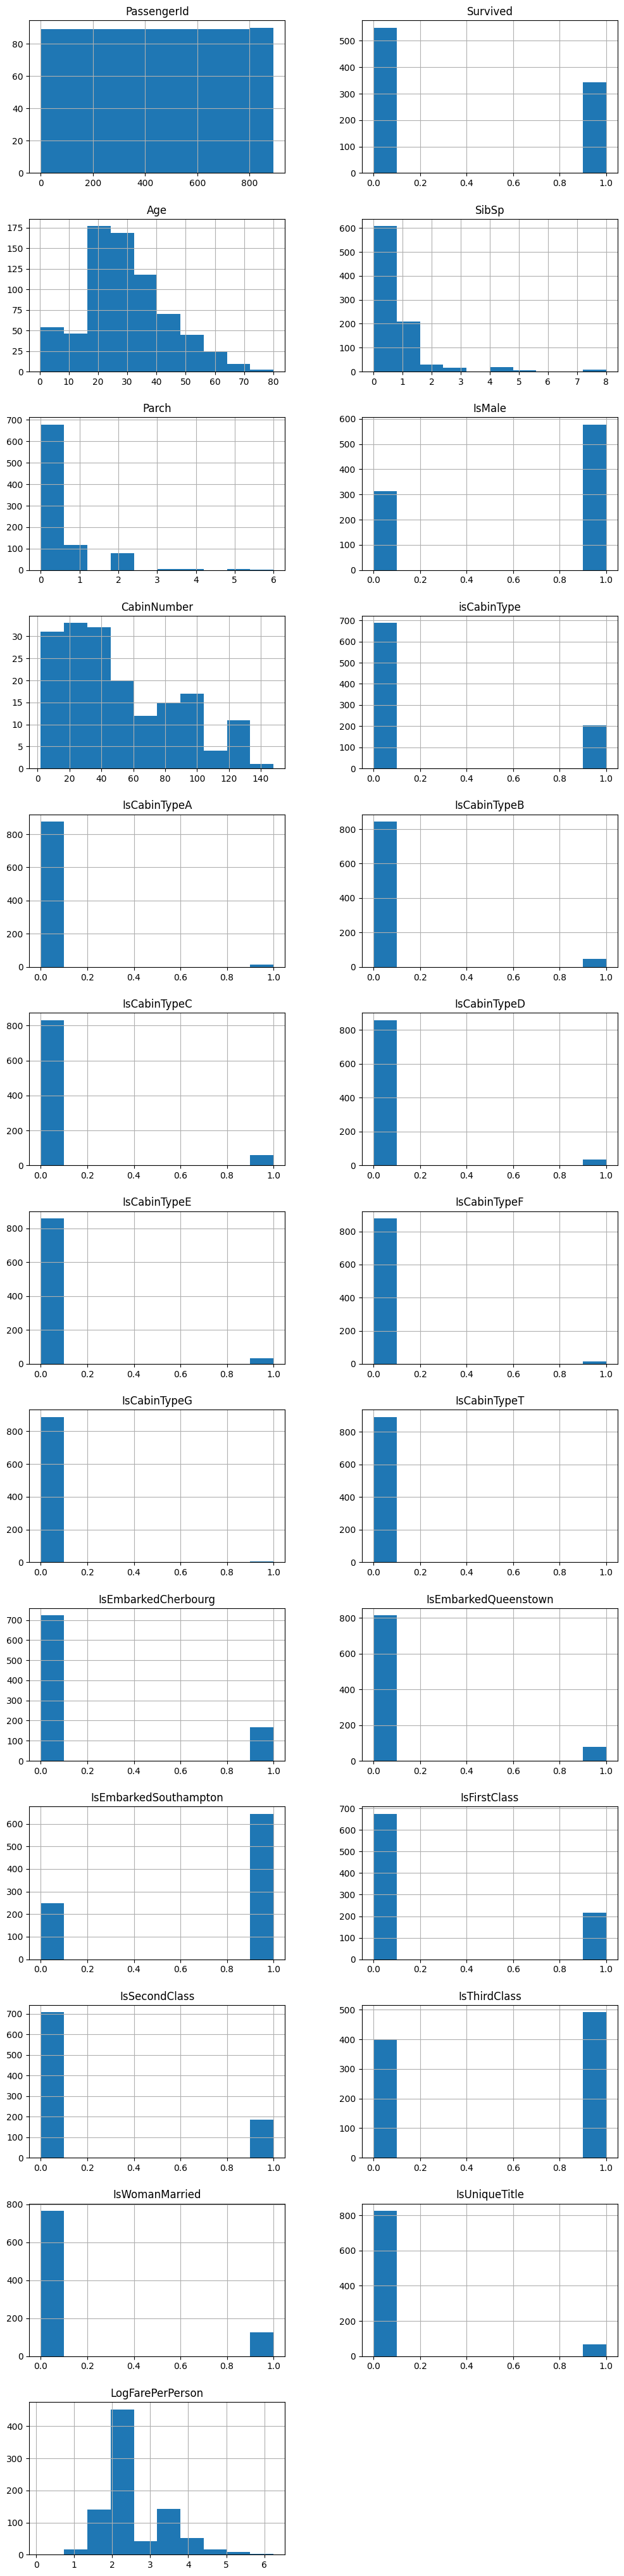

In [25]:
custom_hist(df_train)

In [26]:
def feature_engineering(df):

    return feat_df

Next:

Consider SibSp, Parch to convert to 1/0 bit and then non zero log transform for strong right tail

Consider possible log transform on CabinNumber

Need to work on Ticket maybe split out "unique" tickets with portions in the front prior to the integer
